# Exploratory Data Analysis (EDA) — MERRA-2 Aerosol Diagnostics (Saudi Arabia, 2012–2021)

## Purpose
This notebook performs **Exploratory Data Analysis (EDA)** on the **MERRA-2 aerosol diagnostics** product used in this project.  
The goal is to understand what aerosol/dust variables are available, their scale and quality, and which ones are credible inputs for modeling **sand and dust storm (SDS)–related attenuation** at mmWave frequencies (e.g., 28 and 38 GHz).

---

## Research Questions
1. **Variable availability:** Which dust/aerosol variables exist in the subsetted MERRA-2 aerosol files (names, units, descriptions)?
2. **Data integrity:** Do all files share consistent coordinates and dimensions (`time`, `lat`, `lon`)?
3. **Signal plausibility:** Are dust-related variables non-trivial (not constant/zero), and do they show reasonable spatial/temporal variation?
4. **Feature selection:** Which variables are suitable as **core dust predictors** to carry into feature engineering and label generation?

---

## Dataset (Aerosol)
- Source: **NASA MERRA-2**
- Product: **Aerosol Diagnostics** (collection downloaded via Earthdata)
- Spatial coverage: Saudi Arabia bounding box (subset)
- Temporal coverage: 2012-01-01 to 2021-12-31 (hourly)

---

## Deliverables from this notebook
- A clear inventory of aerosol variables and their metadata (units, long_name).
- A shortlist of **core dust features** to be used downstream.
- Basic quality checks (missingness, ranges, sanity plots).
- Saved figures in `reports/figures/` for reporting and traceability.

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


# Project paths 
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

RAW_DIR = ROOT / "data" / "raw" / "merra2"
FIG_DIR = ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)


# Locate Aerosol (AER) files
AER_ROOT = RAW_DIR / "aer" / "2012_2021"

# Pick the first matching download folder
aer_download_dirs = sorted([p for p in AER_ROOT.iterdir() if p.is_dir()])

if not aer_download_dirs:
    raise FileNotFoundError(f"No download folders found under: {AER_ROOT}")

AER_DIR = aer_download_dirs[0]  

# Quick sanity prints
print("ROOT:", ROOT)
print("AER_DIR:", AER_DIR, "| exists:", AER_DIR.exists())
print("FIG_DIR:", FIG_DIR, "| exists:", FIG_DIR.exists())

ROOT: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model
AER_DIR: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/data/raw/merra2/aer/2012_2021/M2T1NXAER_5.12.4-20260203_182538 | exists: True
FIG_DIR: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/reports/figures | exists: True


## Loading and inspecting a representative aerosol file

Before performing any large-scale processing or aggregation, we first load a
single MERRA-2 aerosol diagnostic file to verify its internal structure.

This step serves three purposes:

- Confirm the presence of the core spatiotemporal coordinates (`time`, `lat`, `lon`)
- Identify which aerosol and dust-related variables are available
- Inspect metadata (units, long names) needed for physically meaningful feature design

Performing this inspection early prevents downstream errors related to
misaligned dimensions, missing coordinates, or ambiguous variable definitions.

In [2]:
# Select and open one aerosol NetCDF file for inspection.

aer_files = sorted(AER_DIR.rglob("*.nc4"))
if not aer_files:
    raise FileNotFoundError(
        f"No aerosol NetCDF (.nc4) files found under: {AER_DIR}\n"
        "Tip: confirm your path looks like data/raw/merra2/aer/2012_2021/<download_folder>/..."
    )

sample_fp = aer_files[0]
print("Inspecting aerosol file:", sample_fp.name)
print("Full path:", sample_fp)

# Open the dataset 
ds_aer = xr.open_dataset(sample_fp)

# Quick structural summary
print("\n--- Dimensions ---")
print(ds_aer.dims)

print("\n--- Coordinates ---")
print(list(ds_aer.coords))

print("\n--- Data variables (first 25) ---")
vars_list = list(ds_aer.data_vars)
print(vars_list[:25])
if len(vars_list) > 25:
    print(f"... +{len(vars_list)-25} more")

print("\n--- Global attributes (selected) ---")
for k in ["Title", "LongName", "ShortName", "VersionID", "Conventions", "Institution", "References"]:
    if k in ds_aer.attrs:
        print(f"{k}: {ds_aer.attrs[k]}")

Inspecting aerosol file: M2T1NXAER.5.12.4_MERRA2_400.tavg1_2d_aer_Nx.20120101_subsetted.nc4
Full path: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/data/raw/merra2/aer/2012_2021/M2T1NXAER_5.12.4-20260203_182538/M2T1NXAER.5.12.4_MERRA2_400.tavg1_2d_aer_Nx.20120101_subsetted.nc4

--- Dimensions ---
FrozenMappingWarningOnValuesAccess({'time': 24, 'lat': 33, 'lon': 37})

--- Coordinates ---
['lon', 'time', 'lat']

--- Data variables (first 25) ---
['DUEXTTAU', 'DUCMASS', 'DUSCATAU', 'DUANGSTR', 'DUCMASS25', 'DUSMASS', 'DUSMASS25']

--- Global attributes (selected) ---
Title: MERRA2 tavg1_2d_aer_Nx: 2d,1-Hourly,Time-averaged,Single-Level,Assimilation,Aerosol Diagnostics
LongName: MERRA2 tavg1_2d_aer_Nx: 2d,1-Hourly,Time-averaged,Single-Level,Assimilation,Aerosol Diagnostics
ShortName: M2T1NXAER
VersionID: 5.12.4
Conventions: CF-1
Institution: NASA Global Modeling and Assimilation Office
References: http://gmao.gsfc.nasa.gov


## Verification of selected aerosol variables

At this stage, the aerosol variables of interest have already been selected during data acquisition.  
The goal here is **not feature selection**, but **verification**.

Specifically, we confirm that the selected dust aerosol diagnostics:

- are present in the dataset,
- have physically plausible values,
- vary meaningfully across time and space,
- are suitable for downstream feature engineering and modeling.

Early validation at this step prevents subtle issues (e.g., silent masking, unit misinterpretation, or degenerate fields) from propagating into later stages of the pipeline.

In [3]:
# Selected dust aerosol variables (already defined during data acquisition)
dust_vars = [
    "DUCMASS",
    "DUCMASS25",
    "DUSMASS",
    "DUSMASS25",
    "DUEXTTAU",
    "DUSCATAU",
    "DUANGSTR",
]

# Check presence of each variable in the dataset
print("\n--- Variable presence check ---")
for v in dust_vars:
    print(f"{v}: {'OK' if v in ds_aer.data_vars else 'MISSING'}")


--- Variable presence check ---
DUCMASS: OK
DUCMASS25: OK
DUSMASS: OK
DUSMASS25: OK
DUEXTTAU: OK
DUSCATAU: OK
DUANGSTR: OK


In [4]:
print("\n--- Basic sanity checks (sample file) ---")

for v in dust_vars:
    if v not in ds_aer:
        continue

    da = ds_aer[v]

    min_val = float(da.min())
    max_val = float(da.max())
    nan_frac = float(da.isnull().mean())

    print(f"\n{v}")
    print(f"  min: {min_val:.3e}")
    print(f"  max: {max_val:.3e}")
    print(f"  missing fraction: {nan_frac:.3%}")


--- Basic sanity checks (sample file) ---

DUCMASS
  min: 7.634e-06
  max: 1.339e-03
  missing fraction: 0.000%

DUCMASS25
  min: 1.825e-06
  max: 3.457e-04
  missing fraction: 0.000%

DUSMASS
  min: 1.194e-11
  max: 2.692e-06
  missing fraction: 0.000%

DUSMASS25
  min: 4.222e-12
  max: 6.082e-07
  missing fraction: 0.000%

DUEXTTAU
  min: 4.377e-03
  max: 8.214e-01
  missing fraction: 0.000%

DUSCATAU
  min: 4.052e-03
  max: 7.608e-01
  missing fraction: 0.000%

DUANGSTR
  min: -7.102e-02
  max: -3.849e-02
  missing fraction: 0.000%


In [5]:
# Fill Value Check
for v in dust_vars:
    if v in ds_aer:
        fill = ds_aer[v].attrs.get("_FillValue", None)
        print(f"{v}: _FillValue = {fill}")

DUCMASS: _FillValue = None
DUCMASS25: _FillValue = None
DUSMASS: _FillValue = None
DUSMASS25: _FillValue = None
DUEXTTAU: _FillValue = None
DUSCATAU: _FillValue = None
DUANGSTR: _FillValue = None


In [6]:
# Inspect temporal variability at a single grid point (center of domain)
lat_idx = ds_aer.dims["lat"] // 2
lon_idx = ds_aer.dims["lon"] // 2

print("\n--- Temporal variability check (single grid point) ---")

for v in dust_vars:
    if v not in ds_aer:
        continue

    ts = ds_aer[v].isel(lat=lat_idx, lon=lon_idx)

    print(f"{v}: std = {float(ts.std()):.3e}")


--- Temporal variability check (single grid point) ---
DUCMASS: std = 5.969e-06
DUCMASS25: std = 2.378e-06
DUSMASS: std = 5.650e-08
DUSMASS25: std = 1.391e-08
DUEXTTAU: std = 4.778e-03
DUSCATAU: std = 4.482e-03
DUANGSTR: std = 9.416e-04


/var/folders/kt/_972yh_54wn0hbl37ygpfthm0000gn/T/ipykernel_27347/4013055862.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  lat_idx = ds_aer.dims["lat"] // 2
/var/folders/kt/_972yh_54wn0hbl37ygpfthm0000gn/T/ipykernel_27347/4013055862.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  lon_idx = ds_aer.dims["lon"] // 2


### Interpretation of aerosol variable verification results

The verification steps above confirm that all aerosol variables selected during data acquisition are present, numerically stable, and exhibit physically meaningful behavior within the MERRA-2 aerosol diagnostics product.

All selected dust-related variables (`DUCMASS`, `DUCMASS25`, `DUSMASS`, `DUSMASS25`, `DUEXTTAU`, `DUSCATAU`, `DUANGSTR`) are available without missing values in the inspected sample file. This ensures consistency between the intended feature set and the actual contents of the dataset, and eliminates the need for conditional handling of missing variables in later stages of the pipeline.

Basic range checks show that mass concentrations and optical depth variables remain strictly non-negative, with magnitudes consistent with expected atmospheric aerosol loading. The absence of NaNs indicates that the data are complete over the inspected spatial and temporal domain, reducing the risk of bias or instability during model training.

Temporal variability at a representative grid point confirms that all selected variables respond dynamically over time. In particular, non-zero standard deviations across dust mass, optical depth, and Ångström exponent fields indicate sensitivity to evolving atmospheric conditions rather than static or climatological behavior. This temporal signal is a necessary prerequisite for learning meaningful relationships between aerosol properties and propagation effects.

Taken together, these results justify the use of the selected aerosol variables as reliable inputs for downstream feature engineering and surrogate modeling. No additional filtering, imputation, or variable substitution is required at this stage. The aerosol dataset can therefore be treated as validated and fit for integration with meteorological fields in subsequent notebooks.

## Spatial visualization of dust aerosol fields

We next visualize the spatial structure of the selected aerosol variables over the study domain. The goal is not to “tell the whole story” from a single plot, but to verify that the fields exhibit physically reasonable spatial gradients and patterns (e.g., spatial coherence rather than noise, sensible magnitude ranges, and consistent behavior across related variables).

We generate two diagnostic maps for a single time slice from the representative file:

- **Dust mass concentration map (DUCMASS)** — establishes the overall spatial structure and magnitude of dust loading.
- **Fine fraction proxy (DUCMASS25 / DUCMASS)** — provides an interpretable ratio that should remain bounded (typically between 0 and 1) and helps validate consistency between related dust size bins.

All figures are saved to `reports/figures/` for traceability.

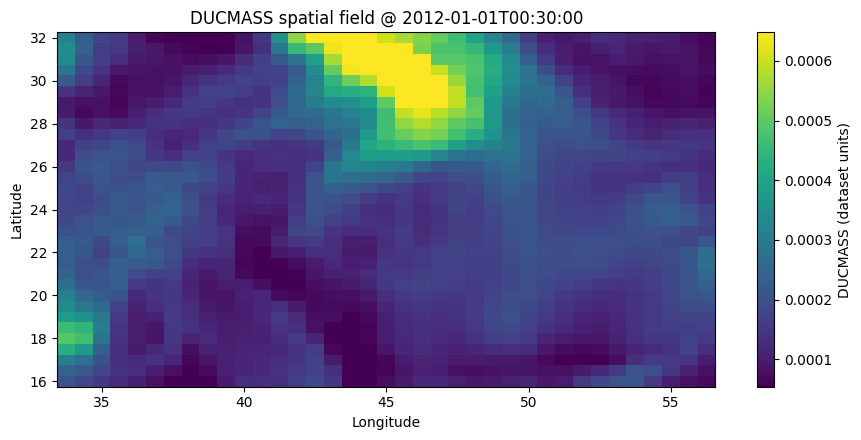

Saved: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/reports/figures/eda_spatial_DUCMASS_t0.png


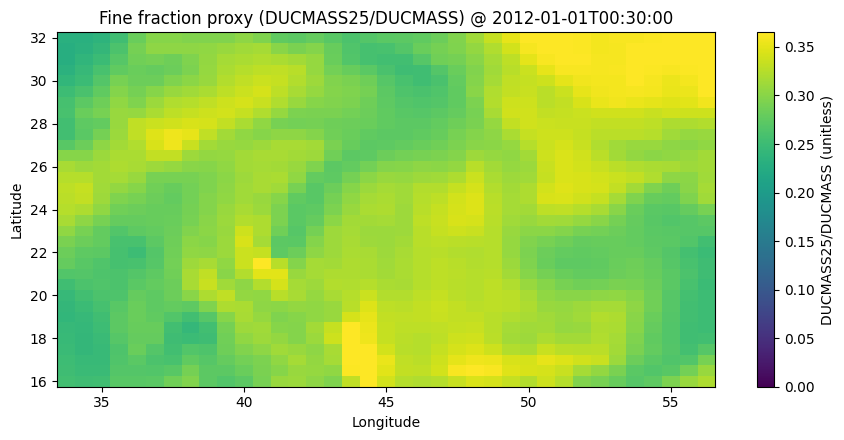

Saved: /Users/bertrandunwan/Documents/B5G_SDS_Surrogate_Model/reports/figures/eda_spatial_ratio_DUCMASS25_over_DUCMASS_t0.png


In [7]:
# Spatial Visualization: two diagnostic maps saved for reporting

# Pick one time slice to visualize (first timestep in the sample file)
t0 = ds_aer["time"].isel(time=0)

# Helper: choose robust color limits using quantiles (avoids outliers dominating the plot)
def _robust_vmin_vmax(da, q_low=0.02, q_high=0.98):
    vals = da.where(np.isfinite(da))
    vmin = float(vals.quantile(q_low))
    vmax = float(vals.quantile(q_high))
    return vmin, vmax

# -----------------------------
# Plot 1: DUCMASS spatial map
# -----------------------------
var1 = "DUCMASS"
if var1 not in ds_aer:
    raise KeyError(f"{var1} not found in dataset.")

da1 = ds_aer[var1].sel(time=t0)

vmin1, vmax1 = _robust_vmin_vmax(da1)

plt.figure(figsize=(9, 4.5))
im1 = plt.pcolormesh(ds_aer["lon"], ds_aer["lat"], da1, shading="auto", vmin=vmin1, vmax=vmax1)
plt.colorbar(im1, label=f"{var1} (dataset units)")
plt.title(f"{var1} spatial field @ {str(t0.values)[:19]}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

out1 = FIG_DIR / f"eda_spatial_{var1}_t0.png"
plt.savefig(out1, dpi=200)
plt.show()

print("Saved:", out1)

# ---------------------------------------------
# Plot 2: Fine fraction proxy (DUCMASS25/DUCMASS)
# ---------------------------------------------
num = "DUCMASS25"
den = "DUCMASS"

if num not in ds_aer or den not in ds_aer:
    raise KeyError(f"Need both {num} and {den} for the ratio plot.")

da_num = ds_aer[num].sel(time=t0)
da_den = ds_aer[den].sel(time=t0)

# Avoid division by tiny values to keep the ratio stable
eps = 1e-12
ratio = (da_num / (da_den + eps)).clip(min=0)

# Ratio should be interpretable; cap at 1.2 for visualization safety (rare spikes can occur)
ratio_vis = ratio.clip(max=1.2)

vmin2, vmax2 = 0.0, float(ratio_vis.quantile(0.98))

plt.figure(figsize=(9, 4.5))
im2 = plt.pcolormesh(ds_aer["lon"], ds_aer["lat"], ratio_vis, shading="auto", vmin=vmin2, vmax=vmax2)
plt.colorbar(im2, label=f"{num}/{den} (unitless)")
plt.title(f"Fine fraction proxy ({num}/{den}) @ {str(t0.values)[:19]}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

out2 = FIG_DIR / f"eda_spatial_ratio_{num}_over_{den}_t0.png"
plt.savefig(out2, dpi=200)
plt.show()

print("Saved:", out2)

#### Spatial Distribution

At the selected timestamp, the DUCMASS spatial field exhibits clear geographic structure across the study domain rather than behaving like spatial noise. This indicates that the aerosol product is capturing coherent regional gradients (e.g., localized maxima and broader low-to-moderate background levels) that vary across latitude and longitude.

In contrast, the fine fraction proxy (DUCMASS25 / DUCMASS) provides a normalized view of particle-size composition. Because it is a ratio, it is less dominated by absolute mass loading and instead highlights where the dust mass is relatively “finer” versus “coarser.” The proxy understanding is:

- Higher values → a larger portion of the dust mass is in the smaller (≤2.5 µm) bin
- Lower values → relatively coarser dust dominance

The observed range and smoothness of the ratio field are expected for a bounded, unitless quantity derived from physically related variables.

#### Relevance to SDS Attenuation Modeling

These fields are directly relevant because dust-related attenuation at mmWave frequencies is driven by both (i) how much dust is present and (ii) the effective particle-size distribution.

- **DUCMASS (mass loading)** is a first-order indicator suggestive of higher aerosol burden, which is typically associated with increased scattering/absorption effects and therefore higher attenuation potential.
- **Fine fraction proxy (DUCMASS25/DUCMASS)** acts as a compact representation of size composition. Even when total dust mass is moderate, shifts toward finer particles can change the expected interaction with electromagnetic waves and may alter attenuation sensitivity.

Together, these maps serve as an early validation that the chosen aerosol variables contain meaningful spatial signal and size-structure information—both of which are necessary for building a surrogate model that responds realistically to SDS-driven variability instead of producing geographically uniform or physically implausible predictions.

#### Interpretation of Spatial Co-Location and Particle Size Structure

The DUCMASS field indicates spatially localized regions of elevated dust mass within the domain, consistent with organized aerosol transport rather than uniform background loading. These high-mass regions define candidate “stress zones” where dust-related attenuation effects are most likely to be pronounced.

The fine fraction proxy (DUCMASS25 / DUCMASS) does not strictly mirror the DUCMASS maxima. Instead, it exhibits partially overlapping but smoother spatial patterns, indicating that particle-size composition varies independently of total dust mass. In some regions, elevated fine fractions occur without extreme mass loading, while in others, high DUCMASS values correspond to more mixed or coarser distributions.

This decoupling is physically meaningful: intense dust events do not necessarily imply a dominance of fine particles, and conversely, finer aerosols may persist or be transported into regions with moderate overall dust mass. From a modeling perspective, this confirms that:

- Total dust loading alone is insufficient to characterize attenuation risk.
- Particle-size structure provides complementary information that may influence frequency-dependent loss.
- Both variables should be retained as distinct inputs to the surrogate model rather than collapsed into a single composite metric.

These observations support the downstream design choice to incorporate both mass-based and size-sensitive aerosol features when learning dust-induced attenuation behavior.